In [42]:
#パッケージのインポート
import numpy as np
import json
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

import torch
import torchvision
from torchvision import models, transforms

In [43]:
#PyTorchのバージョンの確認
print("PyTorch Version:", torch.__version__)
print("Torchvision Version", torchvision.__version__)

PyTorch Version: 1.12.1
Torchvision Version 0.13.1a0


In [44]:
#学習済みのVGG16モデルの読み込み
#VGG16モデルのインスタンスの作成
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained) #学習済みのモデルを使用する
net.eval() #推論モードに設定

#モデルのネットワークの構成を出力
print(net)

/opt/conda/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [45]:
#入力画像の前処理クラスの作成
class BaseTransform():
    """
    画像サイズをリサイズし、色情報の標準化を行う
    Attributes
    ----------
    resize : int
        リサイズ先の家蔵の大きさ
    mean : (R, G, B)
        各色チャネルの平均値
    std : (R, G, B)
        各色チャネルの標準偏差
    """
    def __init__(self, resize, mean, std):
        self.base_transform = transforms.Compose([
            transforms.Resize(resize), #短い辺の長さがresizeの大きさになるようにリサイズ
            transforms.CenterCrop(resize), #画像中央をresize×resizeで切り取り
            transforms.ToTensor(), #テンソルに変換
            transforms.Normalize(mean, std) #色情報の標準化
        ])
    def __call__(self, img):
        return self.base_transform(img)

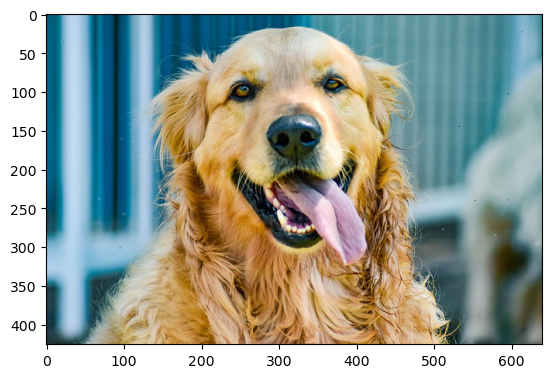

tensor([[[-1.5014, -0.8849, -0.4739,  ..., -0.6452, -0.6109, -0.4397],
         [-1.5014, -0.8678, -0.4739,  ..., -0.6794, -0.5938, -0.4568],
         [-1.4672, -0.8335, -0.4568,  ..., -0.6794, -0.5938, -0.4568],
         ...,
         [ 1.1529,  1.0673,  0.9817,  ..., -1.0562, -1.8268, -1.5870],
         [ 1.1872,  1.2899,  1.3242,  ..., -0.6281, -1.6898, -1.5357],
         [ 1.3242,  1.4612,  1.5639,  ..., -0.7650, -1.4500, -1.5014]],

        [[ 0.1877,  0.4853,  0.7654,  ...,  0.4853,  0.5028,  0.5903],
         [ 0.2052,  0.5203,  0.7479,  ...,  0.4503,  0.5028,  0.5903],
         [ 0.2577,  0.5378,  0.7654,  ...,  0.4503,  0.5203,  0.5728],
         ...,
         [ 0.8354,  0.6954,  0.6078,  ..., -0.6877, -1.2829, -0.9153],
         [ 0.8880,  0.9755,  1.0105,  ..., -0.2325, -1.1429, -0.8803],
         [ 1.0630,  1.2206,  1.3256,  ..., -0.3550, -0.8978, -0.8803]],

        [[ 0.9842,  1.2457,  1.4548,  ...,  0.8622,  0.8797,  1.0017],
         [ 1.0017,  1.2805,  1.4548,  ...,  0

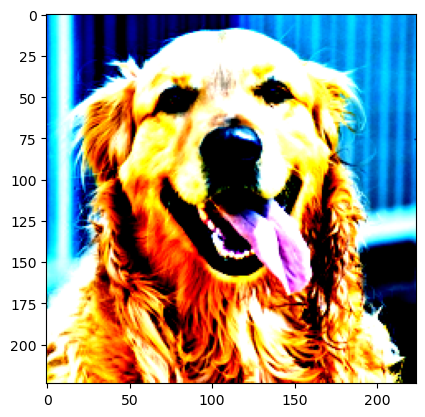

In [46]:
#画像の前処理の動作確認
#1. 画像読み込み
image_file_path = "./data/goldenretriever-3724972_640.jpg"
img = Image.open(image_file_path) #PIL形式　高さ×幅×色チャネル
#2. 画像の表示
plt.imshow(img)
plt.show()
#3. 画像の前処理と表示
resize = 224
mean = (0.485, 0.456, 0.406) #ImageNetの画像の各色チャネルの平均値
std = (0.229, 0.224, 0.225) #ImageNetの画像の各色チャネルの標準偏差
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img) #テンソルサイズの3×224×224に変換
print(img_transformed)
#4.色×高さ×幅を入れ替えて、高さ×幅×色チャネルに変換し、0-1の範囲に変換
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1) #0-1の範囲外の値をクリップ
#5. 処理済みの画像の表示
plt.imshow(img_transformed)
plt.show()


In [47]:
#IlSVRCのラベル情報のファイルを読み込み、辞書型変数に格納
ILSVRC_class_index = json.load(open("./data/imagenet_class_index.json", "r"))
ILSVRC_class_index

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [48]:
#出力結果からラベルを取得する関数の作成
class ILSVRCPredictor():
    """
    ILSVRCデータに対するモデルの出力からラベルを求める
    
    Attributes
    ----------
    class_index : dictionary
        クラスインデックスとラベルの対応を格納した辞書型変数
    """

    def __init__(self,class_index):
        self.class_index = class_index
    
    def predict_max(self, out):
        """
        確率最大のILSVRCのラベル名を取得する

        Parameters
        ----------
        out : torch.Size([1, 1000])
            netからの出力

        Returns
        -------
        pred_label_name : str
            最も予測値の高いラベル名
        """
        maxid = np.argmax(out.detach().numpy())
        predicted_label_name = self.class_index[str(maxid)][1]
        return predicted_label_name


In [50]:
#ILSVRCのラベル情報のファイルを読み込み、辞書型変数に格納
ILSVRC_class_index = json.load(open("./data/imagenet_class_index.json", "r"))
#ILSVRCのインスタンスの作成
predictor = ILSVRCPredictor(ILSVRC_class_index)
#入力画像を読み込む
image_file_path = "./data/goldenretriever-3724972_640.jpg"
img = Image.open(image_file_path)
img
#画像の前処理とバッチサイズの次元を追加
resize = 224
mean = (0.485, 0.456, 0.406) 
std = (0.229, 0.224, 0.225)
transform = BaseTransform(resize, mean, std) #前処理クラスのインスタンスを作成
img_transformed = transform(img) #前処理の実行
inputs = img_transformed.unsqueeze_(0) #バッチサイズの次元を追加
#モデルに入力し、出力をラベルに変換
out = net(inputs)
result = predictor.predict_max(out)
#予測結果の出力
print("入力画像の予測結果：", result)

入力画像の予測結果： golden_retriever
